# Julia の紹介<br><small>機械学習のための Julia</small>

<p style="text-align:center;font-size:150%;line-height:150%">2015/11/28 機械学習 名古屋 第2回勉強会<br>後藤 俊介 ( @antimon2 )</p>

## Julia とは？

- [The Julia Language](http://julialang.org/)
- Python/Ruby/R 等の「いいとこどり」言語（詳細後述）
- 動作が速い！（LLVM JIT コンパイル）

## Julia の特長

> + Rのように中身がぐちゃぐちゃでなく、
+ Rubyのように遅くなく、
+ Lispのように原始的またはエレファントでなく、
+ Prologのように変態的なところはなく、
+ Javaのように硬すぎることはなく、
+ Haskellのように抽象的すぎない
> 
> ほどよい言語である

引用：http://www.slideshare.net/Nikoriks/julia-28059489

Julia の目指すもの：

+ C のように高速だけど、  
  Ruby のような動的型付言語である
+ Lisp のように同じ文法で書けるマクロがあって、しかも  
  Matlab のような直感的な数式表現もできる
+ Python のように総合的なプログラミングができて、  
  R のように統計処理も得意で、  
  Perl のように文字列処理もできて、  
  Matlab のように線形代数もできて、  
  shell のように複数のプログラムを組み合わせることもできる
+ 超初心者にも習得は簡単で、  
  超上級者の満足にも応えられる
+ インタラクティブにも動作して、コンパイルもできる

（[Why We Created Julia](http://julialang.org/blog/2012/02/why-we-created-julia/) から抜粋・私訳）

## 機械学習への適用

自分で実装編。

### 例1：単純な線形回帰

1変数（or 多くても10変数程度）、データ数100件程度  
⇒ 行列作ってバックスラッシュ演算子で高速に求解可能。

In [1]:
# 手作りサンプルデータ
x = rand(100) .* 100
y = randn(100) .* 5 .+ x .* 0.7 .+ 10

# 行列作成
X = [ones(100, 1) x;]

# パラメータ求解（Normal Equation 利用）
# θ = X \ y
θ = (X' * X) \ (X' * y);

※↑この「θ」のように unicode 文字を識別子として利用可能

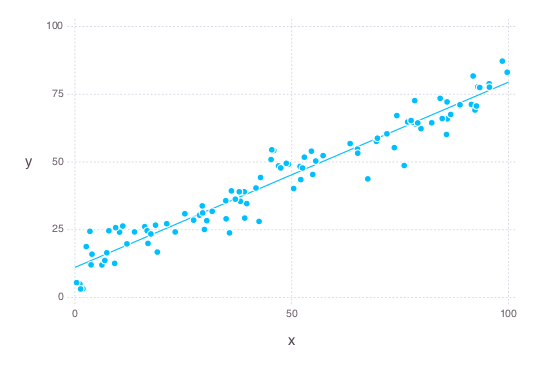

In [2]:
# 結果プロット
using Gadfly  # ← Julia 定番のデータプロットライブラリ

x_linspace = linspace(0,100)
f(x) = θ[1] .+ x .* θ[2]
plot(layer(x=x, y=y, Geom.point), layer(x=x_linspace, y=f(x_linspace), Geom.line))

### 例2：簡単な K-means

本日のハンズオンで利用したサンプルデータを利用。

In [3]:
# データ読込
data = open(readdlm, "./CodeIQ_data.txt", "r")

K=3
X=data;

In [4]:
# クラスタ重心初期化
function initCentroids(X, K)
    randidx = randperm(size(X, 1))
    X[randidx[1:K], :]
end

initCentroids (generic function with 1 method)

In [5]:
# チェック
initialCentroids = initCentroids(X, K)

3x2 Array{Float64,2}:
  3.6   11.73
  4.72  12.13
 10.25   3.02

In [6]:
# クラスタ割り付けステップ
function findClosestCentroids(X, centroids)
    K = size(centroids, 1)
    map(1:size(X, 1)) do i
        x = vec(X[i, :])
        ts = [x - vec(centroids[j,:]) for j=1:K]
        ls = [dot(t, t) for t=ts]
        indmin(ls)
    end
end

findClosestCentroids (generic function with 1 method)

In [7]:
# チェック
idxs = findClosestCentroids(X, initialCentroids)

96-element Array{Int64,1}:
 3
 1
 2
 3
 3
 2
 3
 3
 1
 2
 1
 2
 2
 ⋮
 2
 1
 3
 1
 3
 3
 2
 1
 2
 3
 2
 1

In [8]:
# 重心移動ステップ
function computeCentroids(X, idxs, K)
    m, n = size(X)  # m 不使用
    centroids = zeros(K, n)
    for j = 1:K
        centroids[j, :] = mean(X[idxs .== j, :], 1) # ← idxs が j（=1,2,…,K）の行のみ抽出して、列ごとに平均値を算出
    end
    centroids
end


computeCentroids (generic function with 1 method)

In [9]:
# チェック
computeCentroids(X, idxs, K)

3x2 Array{Float64,2}:
  3.09905  10.7233 
 11.7685   13.5244 
 10.3078    3.35222

In [10]:
# ループ実施
function runKMeans(X, initialCentroids, max_iters=10)
    m, n = size(X)
    K = size(initialCentroids, 1)
    centroids = initialCentroids
    prev_centroids = centroids
    idxs = zeros(m, 1)
    
    for i = 1:max_iters
        idxs = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idxs, K)
        if centroids == prev_centroids
            break
        end
        prev_centroids = centroids
    end
    
    return centroids, idxs
end

runKMeans (generic function with 2 methods)

In [11]:
# 結果表示
function dispResult(X, idxs)
    plotdata = [X [string(i) for i=idxs];]
    plot(x=plotdata[:,1], y=plotdata[:,2], color=plotdata[:,3])
end

dispResult (generic function with 1 method)

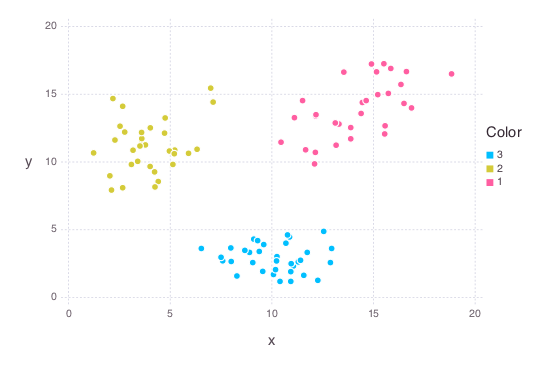

In [12]:
# 実行
initial_centroids = initCentroids(X, K)
centroids, idxs = runKMeans(X, initial_centroids)
dispResult(X, idxs)

※ その他、学習曲線プロット等も可能（省略）

## 機械学習への適用 その2

追加パッケージ利用編。

便利なライブラリは素直に利用しましょう。

### 機械学習ライブラリ（主なもの）

+ [MLBase](https://github.com/JuliaStats/MLBase.jl)（機械学習の基本アルゴリズムを集めたパッケージ。他↓のいくつかのライブラリで required されている）
+ [Regression.jl](https://github.com/lindahua/Regression.jl)（○○回帰（線形回帰、リッジ回帰、ロジスティック回帰等））
+ [LIBSVM](http://github.com/simonster/LIBSVM.jl)（SVMパッケージ。libsvm の Julia ラッパー）
+ [Clustering.jl](https://github.com/JuliaStats/Clustering.jl)（K-means その他クラスタリング）
+ [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl)（決定木、ランダムフォレスト）
+ [BackpropNeuralNet](https://github.com/compressed/BackpropNeuralNet.jl)（ニューラルネット）

### 例1：Clustering.jl で K-means

本日のハンズオンで利用したサンプルデータを利用。

In [13]:
# パッケージ読込
# Pkg.add("Clustering")
using Clustering

In [14]:
# 学習（X, K は先ほど利用したデータ）
model = kmeans(X', K; maxiter=10, display=:iter)

Clustering.KmeansResult{Float64}(2x3 Array{Float64,2}:
 10.1009    3.91875  14.21  
  2.90441  11.1456   13.9303,[1,2,3,1,1,2,1,1,2,3  …  1,2,1,1,3,2,2,1,3,2],[8.57266,6.92678,7.7371,13.2633,0.0355967,5.11937,5.06906,3.04261,2.91053,8.28019  …  0.765279,1.4695,0.88455,9.90113,7.78251,2.4756,1.9285,3.75704,14.6554,15.5151],[34,32,30],[34.0,32.0,30.0],545.1195459313719,3,true)

Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.803598e+03
      1       5.805650e+02      -1.223033e+03 |        2
      2       5.451195e+02      -3.544550e+01 |        0
      3       5.451195e+02       0.000000e+00 |        0
K-means converged with 3 iterations (objv = 545.1195459313719)


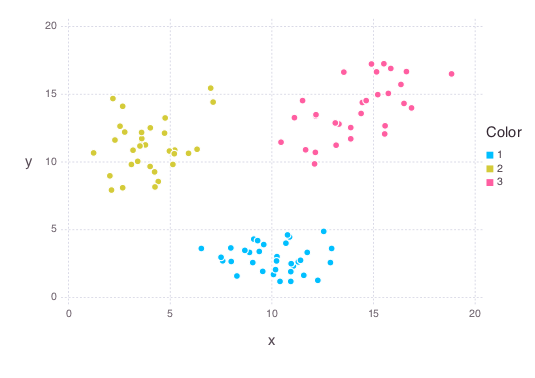

In [15]:
# 結果確認（dispResult 関数は先ほど定義したもの（Clustering パッケージには含まれません））
dispResult(X, model.assignments)

## 参考

+ [The Julia Language](http://julialang.org/)（本家サイト、英語）
+ [X分で学ぶJulia - りんごがでている](http://bicycle1885.hatenablog.com/entry/2014/12/01/050522)（日本語の分かりやすいチュートリアル記事）
+ [Julia - josephmisiti/awesome-machine-learning](https://github.com/josephmisiti/awesome-machine-learning#julia-general-purpose)（Julia の機械学習関連ライブラリのリンクまとめ。英語）